# Sync ER (Model 1)
Mark Disterhof 

mardis@uni-bremen.de

# AWGN case

In [97]:
import numpy as np
from matplotlib import pyplot as plt
from pyphysim.modulators import OFDM
from nrphypy import signals, ssb, decode, threegpp_tdl_channels
from multiprocessing.pool import Pool
from IPython.display import clear_output

def run(snr: float):
    n_lin = 1/np.sqrt(10**(snr/10))
    
    ERR_PSS = 0.
    ERR_SSS = 0.
    ERR_DMRS = 0.
    ERR_PBCH = 0.
    ERR_PBCH_EQ = 0.

    ofdm_modem = OFDM(240, 0, num_used_subcarriers= 240)

    for i in range(n_iter):
        clear_output(wait=True)
        print("Running {0} out of {1} at SNR {2}".format(i,n_iter,snr))
        nid1 = np.random.randint(336) # cell ID group {0,..,335}
        nid2 = np.random.randint(3)   # cell ID sector {0,1,2}
        nidcell = nid1*3 + nid2
        pbch = np.random.randint(2, size=864)
        l_max = 8
        ssb_i = np.random.randint(l_max)
        rgrid = ssb.ssb(nid1,nid2, l_max, ssb_i, pbch)
        s = ofdm_modem.modulate(rgrid.T.flatten())
        s /= np.sqrt(np.mean(np.square(np.abs(s))))

        n = np.array(
            [complex(np.random.normal(0, n_lin, 1) + 1j * np.random.normal(0, n_lin, 1)) 
                 for i in range(len(s))])/np.sqrt(2)
        s_n = s + n
        db = np.log10((np.sqrt(np.mean(np.square(np.abs(s))))/np.sqrt(np.mean(np.square(np.abs(n)))))**2)*10

        # PSS
        dec_pss = decode.pss_correlate(s_n, 240, None)
        ERR_PSS += (1-int(nid2 == dec_pss))/n_iter
        demod = ofdm_modem.demodulate(s_n).reshape((240,4),order='F')
        #SSS
        sss_n = ssb.unmap_sss(demod)
        dec_nid1 = decode.decode_sss(sss_n, nid2)
        ERR_SSS += (1-int(nid1 == dec_nid1))/n_iter
        #DMRS
        rec_pbch, rec_dmrs = ssb.unmap_pbch(demod,nidcell%4)
        dec_ssb_i = decode.dmrs(rec_dmrs, nidcell, l_max)
        ERR_DMRS += (1-int(ssb_i == dec_ssb_i))/n_iter

        #PBCH
        dec_pbch = decode.decode_pbch(rec_pbch,l_max, nidcell, ssb_i)
        ERR_PBCH += (1-(np.sum(dec_pbch == pbch)/len(pbch)))/n_iter

    return np.array([db, ERR_PSS,ERR_SSS,ERR_DMRS,ERR_PBCH])

n_iter = 5000
n_db = np.linspace(-20, -5,15)

pool = Pool()
res = np.array(pool.map(run,n_db),dtype=float)
np.save('./res_awgn.npy',res)

Running 4999 out of 5000 at SNR -5.0


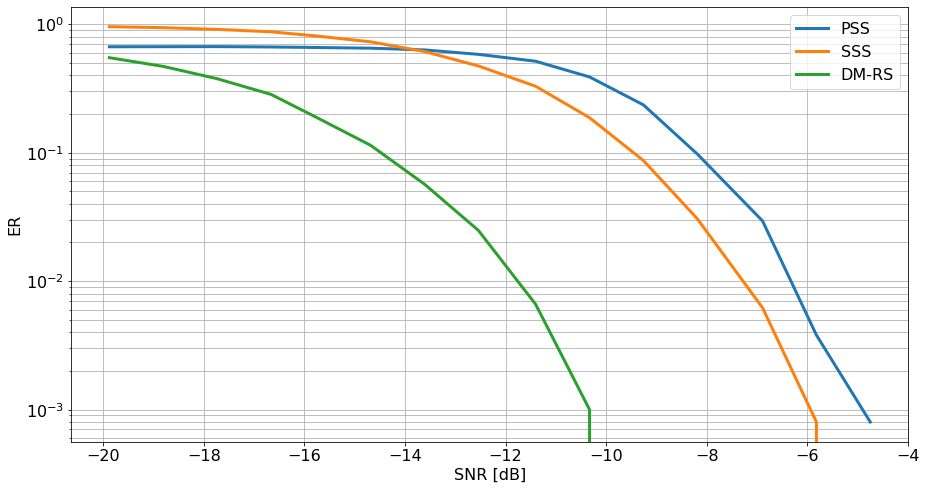

In [23]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
font = {'size'   : 16}
n_iter=5000
matplotlib.rc('font', **font)
res = np.load('./res_awgn.npy')
ERR_PSS,ERR_SSS,ERR_DMRS,_= res[:,1:].T
n_db = res[:,0]
fig, ax = plt.subplots(figsize=(15,8), ncols=1)

ax.set_xlabel('SNR [dB]')
ax.set_ylabel('ER')
ax.grid(True, which="both", ls="-")
lines = ax.semilogy(n_db,ERR_PSS,n_db,ERR_SSS,n_db,ERR_DMRS, linewidth=3)
ax.legend(np.array(lines).flatten(), ['PSS','SSS','DM-RS'])#

plt.savefig("./im/m1_awgn_{0}iter.pdf".format(n_iter), bbox_inches = 'tight',
    pad_inches = 0)

# TDL + AWGN Case

In [95]:
import numpy as np
from matplotlib import pyplot as plt
from pyphysim.channels.fading import COST259_RAx, TdlChannel, TdlChannelProfile
from pyphysim.channels.fading_generators import JakesSampleGenerator, RayleighSampleGenerator
from pyphysim.modulators import OFDM
from nrphypy import signals, ssb, decode, threegpp_tdl_channels
from multiprocessing.pool import Pool
from IPython.display import clear_output

def run(snr: float):
    
    ERR_PSS = 0.
    ERR_SSS = 0.
    ERR_DMRS = 0.
    ERR_PBCH = 0.
    ERR_PBCH_EQ = 0.
    db= 0.

    ofdm_modem = OFDM(N_SC, 0, num_used_subcarriers= N_SC)

    for i in range(n_iter):
        clear_output(wait=True)
        print("Running {0} out of {1} at SNR {2}".format(i,n_iter,snr))
        nid1 = np.random.randint(336) # cell ID group {0,..,335}
        
        jakesObj = JakesSampleGenerator(Fd, Ts, L=10)
        prof = TdlChannelProfile(*threegpp_tdl_channels.get_channel_profile('TDL_A', ds_desired = 0.5*Ts))      
        channel = TdlChannel(jakesObj, prof)
        n_lin = 1/np.sqrt(10**(snr/10))
        
        nid2 = np.random.randint(3)   # cell ID sector {0,1,2}
        nidcell = nid1*3 + nid2
        pbch = np.random.randint(2, size=864)
        l_max = 8
        ssb_i = np.random.randint(l_max)
        rgrid = ssb.ssb(nid1,nid2, l_max, ssb_i, pbch)
        s = ofdm_modem.modulate(rgrid.T.flatten())
        s /= np.sqrt(np.mean(np.square(np.abs(s))))

        
        s_tdl = channel.corrupt_data(s).flatten()
        n = np.array(
            [complex(np.random.normal(0, n_lin, 1) + 1j * np.random.normal(0, n_lin, 1)) 
                 for i in range(len(s_tdl))])/np.sqrt(2)
        s_n = s_tdl + n
        db += (np.log10((np.sqrt(np.mean(np.square(np.abs(s))))/np.sqrt(np.mean(np.square(np.abs(n)))))**2)*10)/n_iter
        
        # PSS
        dec_pss = decode.pss_correlate(s_n, N_SC, None)
        ERR_PSS += (1.-int(nid2 == dec_pss))/float(n_iter)
        demod = ofdm_modem.demodulate(s_n[:N_SC*4]).reshape((240,4),order='F')
        #SSS
        
        sss_n = ssb.unmap_sss(demod)
        dec_nid1 = decode.decode_sss(sss_n, nid2)
        ERR_SSS += (1.-int(nid1 == dec_nid1))/float(n_iter)
        #DMRS
        rec_pbch, rec_dmrs = ssb.unmap_pbch(demod,nidcell%4)
        dec_ssb_i = decode.dmrs(rec_dmrs, nidcell, l_max)
        ERR_DMRS += (1.-int(ssb_i == dec_ssb_i))/float(n_iter)

        #PBCH
        dec_pbch = decode.decode_pbch(rec_pbch,l_max, nidcell, ssb_i)
        ERR_PBCH += (1.-(np.sum(dec_pbch == pbch)/len(pbch)))/float(n_iter)
        
        # Equalized PBCH
        rec_eq_pbch,_ = ssb.unmap_pbch(decode.dmrs_eq(demod, ssb_i, nidcell,l_max),nidcell%4)
        dec_eq_pbch = decode.decode_pbch(rec_eq_pbch,l_max, nidcell, ssb_i)
        ERR_PBCH_EQ += (1.-(np.sum(dec_eq_pbch == pbch)/len(pbch)))/float(n_iter)
        
    return np.array([db, ERR_PSS,ERR_SSS,ERR_DMRS,ERR_PBCH,ERR_PBCH_EQ])

n_iter = 5000
n_db = np.linspace(-15, 10,25)

N_SC = 240
mu = 0
bandwidth = 2**mu * 15e3 * N_SC
Ts = 1. / bandwidth  # Sampling interval
Fd = 0

pool = Pool()
res = np.array(pool.map(run,n_db),dtype=float)
np.save('./res_tdl.npy',res)

Running 4999 out of 5000 at SNR 10.0


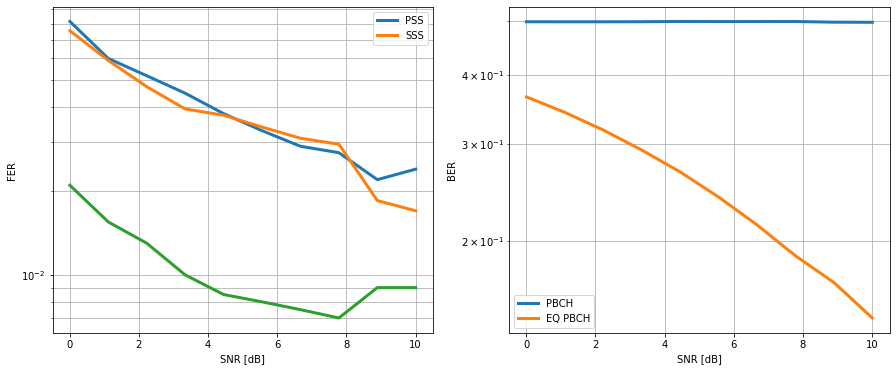

In [92]:
res = np.load('./res_tdl.npy')
ERR_PSS,ERR_SSS,ERR_DMRS,ERR_PBCH,ERR_EQ_PBCH = res[:,1:].T
n_db = res[:,0]
fig, [ax,ax1] = plt.subplots(figsize=(15,6), ncols=2)

ax.set_xlabel('SNR [dB]')
ax.set_ylabel('FER')
ax.grid(True, which="both", ls="-")
ax.legend(np.array(lines).flatten(), ['PSS','SSS','DM-RS'])#
ax = ax.semilogy(n_db,ERR_PSS,n_db,ERR_SSS,n_db,ERR_DMRS, linewidth=3)

ax1.set_xlabel('SNR [dB]')
ax1.set_ylabel('BER')
ax1.grid(True, which="both", ls="-")
ax1.legend(np.array(lines).flatten(), ['PBCH','EQ PBCH'])
ax1 = ax1.semilogy(n_db,ERR_PBCH,n_db,ERR_EQ_PBCH, linewidth=3)

plt.savefig("./im/m1_tdl_{0}iter.pdf".format(n_iter), bbox_inches = 'tight',
    pad_inches = 0)

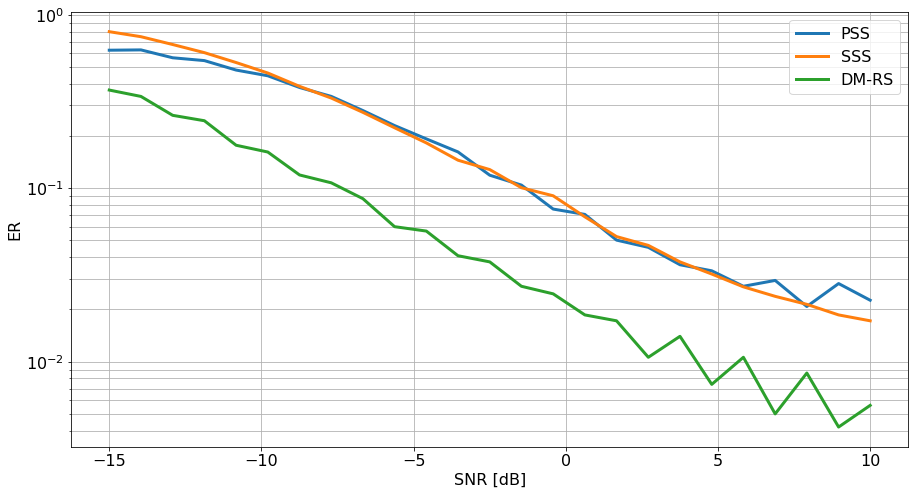

In [22]:
res = np.load('./res_tdl.npy')
ERR_PSS,ERR_SSS,ERR_DMRS,ERR_PBCH,ERR_EQ_PBCH = res[:,1:].T
n_db = res[:,0]

fig, ax = plt.subplots(figsize=(15,8), ncols=1)

ax.set_xlabel('SNR [dB]')
ax.set_ylabel('ER')
ax.grid(True, which="both", ls="-")
lines = ax.semilogy(n_db,ERR_PSS,n_db,ERR_SSS,n_db,ERR_DMRS, linewidth=3)
ax.legend(np.array(lines).flatten(), ['PSS','SSS','DM-RS'])#

plt.savefig("./im/m1_tdl_{0}iter.pdf".format(n_iter), bbox_inches = 'tight',
    pad_inches = 0)

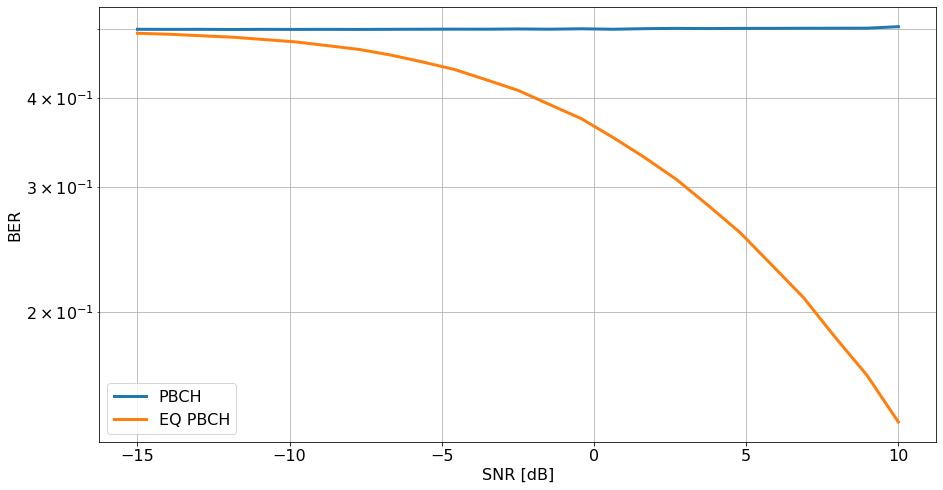

In [21]:
fig, ax = plt.subplots(figsize=(15,8), ncols=1)

ax.set_xlabel('SNR [dB]')
ax.set_ylabel('BER')
ax.grid(True, which="both", ls="-")
lines = ax.semilogy(n_db,ERR_PBCH,n_db,ERR_EQ_PBCH, linewidth=3)
ax.legend(np.array(lines).flatten(), ['PBCH','EQ PBCH'])

plt.savefig("./im/m1_tdl_{0}iter_pbch.pdf".format(n_iter), bbox_inches = 'tight',
    pad_inches = 0)